In [0]:
!pip3 install pymorphy2
!pip3 install pymystem3 --upgrade

Requirement already up-to-date: pymystem3 in /usr/local/lib/python3.6/dist-packages (0.2.0)


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import os

import re

import pymorphy2
DATA_PATH = '/content/gdrive/My Drive/avito'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def read_data(file, **args):
    return pd.read_csv(os.path.join(DATA_PATH, file), **args)

def save_data(df, file, **args):
    df.to_csv(os.path.join(DATA_PATH, file), index=False, **args)

# Лемматизация


In [0]:
def lemmatize(file):
    """
    lemmatizes words in ad's title and description
    file: csv file whic containes 'title' and 'desciption' columns
    """
    data = self.read_data(file)
    assert('title' in data.columns and 'desciption' in data.columns)
    data.title = data.title.str.lower()
    data.description = data.description.str.lower()

    m = Mystem()
    def lemmatize_by_row(text):
        lemmas = m.lemmatize(text)
        return ''.join(lemmas)

    data.title = data.title.progress_apply(lemmatize_by_row)
    data.description = data.description.progress_apply(lemmatize_by_row)

    return data

In [0]:
if not "train_lemmatized.csv" in os.listdir(DATA_PATH):
    train = lemmatize('train.csv')
    save_data(train, "train_lemmatized.csv")

In [0]:
if not "test_lemmatized.csv" in os.listdir(DATA_PATH):
    train = lemmatize('test.csv')
    save_data(train, "test_lemmatized.csv")

# Удаляем пунктуацию, стоп-слова

In [0]:
def clean_str(s):
    # удаляет пунктуацию
    s = re.sub(r"[0-9]|-|\/|\(|\)|,|\.|:|;|!|\+|\-|_|«|»|\"|\'", ' ', s)

    # убирает слова, которы меньше 2
    s = re.sub(r"\b\w{1,2}\b", ' ' ,s)
    return " ".join(s.split())
  
  
def clean_str_only_nouns(s):
  # удаляет пунктуацию
  s = re.sub(r"[0-9]|-|\/|\(|\)|,|\.|:|;|!|\+|\-|_|«|»|\"|\'", ' ', s)
  
  # убирает слова, которы меньше 2
  s = re.sub(r"\b\w{1,2}\b", ' ' ,s)
  
  # выбирает уникальные токены
  s = list(set(s.split()))
  
  tokens = []
  for token in s:
    if ('NOUN' in morph.parse(token)[0].tag):
      tokens.append(token)
  
  return " ".join(tokens)
  

def preprocces_df(data):
    data.title = data.title.progress_apply(clean_str)
    data.description = data.description.progress_apply(clean_str)
    
    return data

In [0]:
!rm /content/gdrive/My\ Drive/avito/preprocessed_train.csv

In [0]:
if not "preprocessed_train.csv" in os.listdir(DATA_PATH):
    data = read_data("train_lemmatized.csv")
    data = preprocces_df(data)
    save_data(data, "preprocessed_train.csv")

100%|██████████| 489517/489517 [00:26<00:00, 18475.11it/s]


In [0]:
!rm /content/gdrive/My\ Drive/avito/preprocessed_test.csv

In [0]:
if not "preprocessed_test.csv" in os.listdir(DATA_PATH):
    data = read_data("test_lemmatized.csv")
    data = preprocces_df(data)
    save_data(data, "preprocessed_test.csv")

100%|██████████| 243166/243166 [00:13<00:00, 17857.20it/s]


# Подготавливаем датасет для  fasttext

In [0]:
def prepare_data_for_fasttext(data, file, mode):
    if mode == "train":
        with open(os.path.join(DATA_PATH, file), 'w') as f:
            for category_id, title, description in tqdm(data.loc[:, ['category_id', 'title', 'description']].values):
                s = title + " " + description
                s = f"__label__{category_id}" + " " + s
                print(s, file=f)
    elif mode == "test":
        with open(os.path.join(DATA_PATH, file), 'w') as f:
            for title, description in tqdm(data.loc[:, ['title', 'description']].values):
                s = title + " " + description
                print(s, file=f)   
    else:
      raise RuntimeError(f"Uknown mode give: {mode}! only train and test modes are available")

In [0]:
if not "fasttext_input.txt" in os.listdir(DATA_PATH):
    data = read_data("preprocessed_train.csv")
    data.fillna("", inplace=True)
    prepare_data_for_fasttext(data, 'fasttext_input.txt', "train")

In [0]:
!head /content/gdrive/My\ Drive/avito/fasttext_input.txt

__label__19 картина гобелен размер
__label__22 стул прессованный кожа продавать недорого стул светлый прессованный кожа стильный ножка дугообразный
__label__37 домашний мини баня мини баня мини сауна предназначать для принятие тепловой процедура бытовой условие дом дача также спортивный оздоровительный косметический лечебный организация учреждение она оказывать общеукрепляющий профилактический действие организм человек номинальный напряжение переменный ток максимальный мощность максимальный температура нагревать воздух термочехол градус – время достижение рабочий температура мина время достижение максимальный температура мина габаритный размер тепловой камера рабочий состояние более длина ширина высота масса мини баня становиться отличный подарок как для мужчина так для женщина
__label__43 эксклюзивный коллекция книга трансаэро подарок продавать эксклюзивный коллекция книга выпускать ограниченный тираж заказ авиакомпания трансаэро серия детектив трансаэро коллекция входить книга габори

In [0]:
if not "preprocessed_test.txt" in os.listdir(DATA_PATH):
    data = read_data("preprocessed_test.csv")
    data.fillna("", inplace=True)
    prepare_data_for_fasttext(data, 'fasttext_test.txt', "test")

100%|██████████| 243166/243166 [00:01<00:00, 146872.14it/s]


In [0]:
!head /content/gdrive/My\ Drive/avito/fasttext_test.txt

стоик журнальный сталь продавать журнальный столик изготовлять стол полировать нержавеющий сталь стекло или камень весь продукция давать гарантия стоимость зависеть размер дизайн
iphone телефон хороший состояние комплект гарантия салон сотовый связь огромный выбор аксессуар запчасть новый сотовый телефон возможный обмен ремонт сотовый телефон график работа
утеплитель теплопельный лидер тепло толщина утеплитель утеплитель безопасный для человек окружающий среда состав утеплитель основа полиэтилен отражать слой чистый алюминиевый фольга металлизировать лавсановый или полипропиленовый пленка весь этот компонент широко использоваться быт пищевой промышленность медицина обладать очень низкий стабильный коэффициент теплопроводность высокий процент теплоотражение эффективно сохранять тепло зима прохлада лето также утеплитель пропускать пар впитывать влага обладать хороший шумоизоляция основной свойство материал низкий теплопроводность теплоотражение экологический безопасность долговечность во

In [0]:
%%shell
wc  /content/gdrive/My\ Drive/avito/fasttext_input.txt
wc  /content/gdrive/My\ Drive/avito/fasttext_test.txt

   489517  16172964 225688054 /content/gdrive/My Drive/avito/fasttext_input.txt
   243166   7761565 108643083 /content/gdrive/My Drive/avito/fasttext_test.txt


# Делим выборку на train и validation

In [0]:
%%shell

head -n 398400 /content/gdrive/My\ Drive/avito/fasttext_input.txt > fastText/fasttext_input.train.txt
tail -n 91117 /content/gdrive/My\ Drive/avito/fasttext_input.txt > fastText/fasttext_input.val.txt

head -n 398400 /content/gdrive/My\ Drive/avito/preprocessed_train.csv > /content/gdrive/My\ Drive/avito/preprocessed_train.train.csv
tail -n 91117 /content/gdrive/My\ Drive/avito/preprocessed_train.csv > /content/gdrive/My\ Drive/avito/preprocessed_train.val.csv

In [0]:
!cd fastText && ls
!cd fastText && wc fasttext_input_no_labels.val.txt 

alignment			  MANIFEST.in
args.o				  matrix.o
classification-example.sh	  meter.o
classification-results.sh	  model_fasttext_avito.bin
CMakeLists.txt			  model.o
CODE_OF_CONDUCT.md		  productquantizer.o
CONTRIBUTING.md			  python
crawl				  quantization-example.sh
densematrix.o			  quantmatrix.o
dictionary.o			  README.md
docs				  runtests.py
eval.py				  scripts
fasttext			  setup.cfg
fasttext_input_no_labels.val.txt  setup.py
fasttext_input.train.txt	  src
fasttext_input.val.txt		  tests
fasttext.o			  utils.o
get-wikimedia.sh		  vector.o
LICENSE				  website
loss.o				  wikifil.pl
Makefile			  word-vector-example.sh
0 0 0 fasttext_input_no_labels.val.txt


In [0]:
# сохраним заголовки в preprocessed_train.val.csv
train = read_data("preprocessed_train.train.csv")
val = read_data("preprocessed_train.val.csv", header=None, names=train.columns)
save_data(val, "preprocessed_train.val.csv")

проверим, что распределение целевой переменной на трейне и валидации совпадает с распределением на всей тренировочной выборке

In [0]:
import matplotlib.pyplot as plt

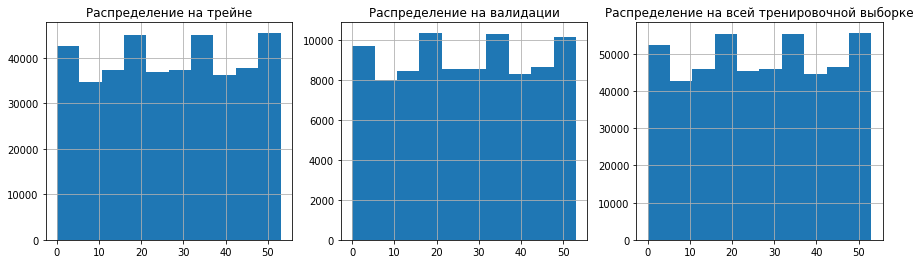

In [0]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

train = read_data("preprocessed_train.train.csv")
train.category_id.hist(ax=axes[0])
axes[0].set_title("Распределение на трейне")

val = read_data("preprocessed_train.val.csv")
val.category_id.hist(ax=axes[1])
axes[1].set_title("Распределение на валидации")

whole_train = pd.concat([train, val])
whole_train.category_id.hist(ax=axes[2])
axes[2].set_title("Распределение на всей тренировочной выборке");

из гистрограмм видно, что распределение на трейне и валидации примерно совпадают с исходным распределением на всей тренировочной выборке